In [ ]:
!pip install mlflow --quiet
!pip install pyngrok --quiet
!pip install boto3
!pip install -q shap
!pip install pyyaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━

In [ ]:
import os
import warnings
import sys
import pandas as pd
import numpy as np
import xgboost

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential

from urllib.parse import urlparse
import yaml
import mlflow
import mlflow.sklearn
import logging
import boto3
import shap

import matplotlib.pyplot as plt

from shap.plots import *
from mlflow.utils.file_utils import TempDir

In [ ]:
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
#yaml file on the upper level to protect rest of the data
os.chdir('/content/drive/My Drive/')

In [ ]:
with open('/content/drive/My Drive/conf/mlconfig.yml') as f:
    data = yaml.load(f, Loader=yaml.FullLoader)
    #print(data['remote_server_uri'])
    #print(data['username'])

https://mlflow.pub.semanticlab.net/
weblyzard


In [ ]:
def preprocessing(data):
  #this is simply a trick to remove the last column which tends to be always NaN for some reason
  data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
  #print(data)
  data.drop(columns='End-Date', inplace=True)

  data["Price_Change_rel"] = pd.to_numeric(data["Price_Change_rel"], downcast="float")
  data["Schädling-TotalFrequency"] = pd.to_numeric(data["Schädling-TotalFrequency"], downcast="float")
  data["Schädling-MeanSentiment"] = pd.to_numeric(data["Schädling-MeanSentiment"], downcast="float")
  data["GeneralWoodDamage-TotalFrequency"] = pd.to_numeric(data["GeneralWoodDamage-TotalFrequency"], downcast="float")
  data["GeneralWoodDamage-MeanSentiment"] = pd.to_numeric(data["GeneralWoodDamage-MeanSentiment"], downcast="float")
  data["Wetter-TotalFrequency"] = pd.to_numeric(data["Wetter-TotalFrequency"], downcast="float")
  data["Wetter-MeanSentiment"] = pd.to_numeric(data["Wetter-MeanSentiment"], downcast="float")
  data["Folgeindustrie-TotalFrequency"] = pd.to_numeric(data["Folgeindustrie-TotalFrequency"], downcast="float")
  data["Folgeindustrie-MeanSentiment"] = pd.to_numeric(data["Folgeindustrie-MeanSentiment"], downcast="float")
  data["rolling-Schädling-MeanSentiment"] = pd.to_numeric(data["rolling-Schädling-MeanSentiment"], downcast="float")
  data["rolling-GeneralWoodDamage-MeanSentiment"] = pd.to_numeric(data["rolling-GeneralWoodDamage-MeanSentiment"],
                                                                    downcast="float")
  data["rolling-Wetter-MeanSentiment"] = pd.to_numeric(data["rolling-Wetter-MeanSentiment"], downcast="float")
  data["rolling-Folgeindustrie-MeanSentiment"] = pd.to_numeric(data["rolling-Folgeindustrie-MeanSentiment"],
                                                                 downcast="float")

  data.drop(columns='BEDAT', inplace=True)
  X = data.drop(['Price_Change_rel'],axis=1).values
  y = data['Price_Change_rel']
  return train_test_split(X, y, test_size=0.2)

In [ ]:
def eval_metrics(actual, pred):
  rmse = np.sqrt(mean_squared_error(actual, pred))
  mae = mean_absolute_error(actual, pred)
  r2 = r2_score(actual, pred)
  return rmse, mae, r2

In [ ]:
def get_model(params, input_shape):
	model = Sequential()
	model.add(GRU(units=params["gru_units"], return_sequences=True, input_shape=(input_shape, 1)))
	model.add(Dropout(rate=params["dropout"]))

	model.add(GRU(units=params["gru_units"], return_sequences=True))
	model.add(Dropout(rate=params["dropout"]))

	model.add(GRU(units=params["gru_units"], return_sequences=True))
	model.add(Dropout(rate=params["dropout"]))

	model.add(GRU(units=params["gru_units"], return_sequences=False))
	model.add(Dropout(rate=params["dropout"]))

	model.add(Dense(1))

	model.compile(loss=params["loss"],
              	optimizer=params["optimizer"],
              	metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

	return model

In [ ]:
def mlflow_start():
  remote_server_uri = data['remote_server_uri']
  user_name = data['username']
  password = data['password']
  mlflow.set_tracking_uri(remote_server_uri)
  os.environ['MLFLOW_TRACKING_USERNAME'] = user_name
  os.environ['MLFLOW_TRACKING_PASSWORD'] = password
  os.environ['MLFLOW_S3_ENDPOINT_URL'] = data['s3_enpoint_url']
  os.environ['AWS_ACCESS_KEY_ID'] = data['aws_access_key_id']
  os.environ['AWS_SECRET_ACCESS_KEY'] = data['aws_secret_access_key']

#mlflow_start()
mlflow_start()

https://mlflow.pub.semanticlab.net/


        BEDAT  Price_Change_rel  End-Date  Schädling-TotalFrequency  \
0  2019-01-01          0.000428  1/1/2019                       0.0   
1  2019-01-02          0.000428  1/2/2019                       1.0   
2  2019-01-03          0.000428  1/3/2019                       3.0   
3  2019-01-04          0.000428  1/4/2019                       3.0   
4  2019-01-05          0.000428  1/5/2019                       0.0   

   Schädling-MeanSentiment  GeneralWoodDamage-TotalFrequency  \
0                     0.00                               1.0   
1                    -0.06                               1.0   
2                    -0.97                               0.0   
3                     0.01                               1.0   
4                     0.00                               0.0   

   GeneralWoodDamage-MeanSentiment  Wetter-TotalFrequency  \
0                             0.00                    0.0   
1                            -0.41                    1.0   
2    

Schädling-MeanSentiment
GeneralWoodDamage-MeanSentiment


Permutation explainer: 668it [1:30:17,  8.13s/it]
2022/09/03 11:33:13 INFO mlflow.tensorflow: Validating the specified TensorFlow model by attempting to load it in a new TensorFlow graph...
2022/09/03 11:33:22 INFO mlflow.tensorflow: Validation succeeded!
2022/09/03 11:33:22 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/09/03 11:33:32 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.14+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLflow logged a pip requirement for this package as 'jaxlib==0.3.14' without the local version label to make it installable from PyPI. To specify pip requirements con

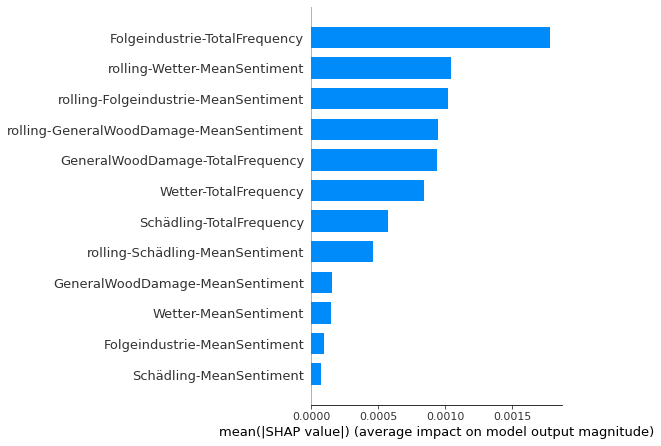

In [ ]:
def main():
  warnings.filterwarnings("ignore")
  np.random.seed(40)

  #data = []

  try:
    #ds = 'softwoodshort'
    #ds = 'hardwoodshort'
    #ds = 'nadelholz'
    ds = 'rohpapier'

    dataset_drive = data['dataset_drive']
    experiment_name = data['experiment_name']
    dataset = dataset_drive + ds + ".csv"
    with open(dataset) as f:
      data = pd.read_csv(f, delimiter=',')
      print(data.head())

      X_train, X_test, y_train, y_test = preprocessing(data)

      n_estimators = 100 #int(sys.argv[1]) if len(sys.argv) > 1 else 1000
      max_features = 9 #int(sys.argv[2]) if len(sys.argv) > 2 else 9
      max_depth = 5 #int(sys.argv[3]) if len(sys.argv) > 3 else 5

      mlflow.end_run()
      mlflow.set_experiment(experiment_name)

      with mlflow.start_run(run_name='gru_rohpapier') as run:
          np.seterr(invalid='ignore')

          params = {
              "loss": "mean_squared_error",
              "optimizer": "adam",
              "dropout": 0.5,
              "gru_units": 60,
              "epochs": 30,
              "batch_size": 8,
              "es_patience": 10
          }

          model = get_model(params=params, input_shape=X_train.shape[1])

          es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                                       mode='min',
                                                       patience=params["es_patience"])

          model.fit(
              X_train,
              y_train,
              validation_data=(X_test, y_test),
              epochs=params["epochs"],
              batch_size=params["batch_size"],
              verbose=1
              #callbacks=[neptune_callback, es_callback]
          )

          y_pred = model.predict(X_test)

          (rmse, mae, r2) = eval_metrics(y_test, y_pred)
          print("GRU model (n_estimators=%d, max_features=%d, max_depth=%d):" % (
          n_estimators, max_features, max_depth))
          print("  RMSE: %s" % rmse)
          print("  MAE: %s" % mae)
          print("  R2: %s" % r2)

          #TODO mlflow flavor
          mlflow.log_param("ds", ds)
          mlflow.log_param("n_estimators", n_estimators)
          mlflow.log_param("max_features", max_features)
          mlflow.log_param("max_depth", max_depth)
          metrics = {"rmse": float(rmse), "r2": float(r2), "mae": float(mae)} 
          #mlflow.log_metric("rmse", rmse)
          #mlflow.log_metric("r2", r2)
          #mlflow.log_metric("mae", mae)
          mlflow.log_metrics(metrics)

          tf.keras.models.save_model(model, "./model")

          featurenames = ["Schädling-TotalFrequency","Schädling-MeanSentiment","GeneralWoodDamage-TotalFrequency","GeneralWoodDamage-MeanSentiment","Wetter-TotalFrequency","Wetter-MeanSentiment","Folgeindustrie-TotalFrequency","Folgeindustrie-MeanSentiment","rolling-Schädling-MeanSentiment","rolling-GeneralWoodDamage-MeanSentiment","rolling-Wetter-MeanSentiment","rolling-Folgeindustrie-MeanSentiment"]

          print(featurenames[1])
          print(featurenames[3])

          # Fits the explainer
          explainer = shap.Explainer(model.predict, X_train, feature_names = featurenames)
          # Calculates the SHAP values - It takes some time
          shap_values = explainer(X_train)
          #shap_values = explainer.shap_values(X_test)
          
          #shap.plots.bar(shap_values, max_display=12)
          #shap.plots.bar(shap_values[0], max_display=12)
          #shap.plots.waterfall(shap_values[0], max_display=12)

          shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=12, show=False)
          import matplotlib.pyplot as plt
          plt.savefig("summary_plot.png")

          mlflow.log_artifact('summary_plot.png')

          tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

          if tracking_url_type_store != "file":
            #mlflow.sklearn.log_model(model, "model", registered_model_name="GRU")
            from tensorflow.python.saved_model import signature_constants
            #v2 models
            #tag=[tf.saved_model.tag_constants.SERVING]
            #v1 models
            tag = [tf.compat.v1.saved_model.tag_constants.SERVING]
            key=signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY

            mlflow.tensorflow.log_model(tf_saved_model_dir="./model",
                                        tf_meta_graph_tags=tag,
                                        tf_signature_def_key=key,
                                        artifact_path="tf-models",
                                        registered_model_name="GRU")
            
            #mlflow.sklearn.log_model(model, "model", registered_model_name="GRU")
            mlflow.log_dict(metrics, "dir/data.json")
          else:
            mlflow.sklearn.log_model(model, "model")

  except Exception as e:
    logger.exception(
        "Unable to download training & test CSV, check your internet connection. Error: %s", e
    )


main()